# C04. Players

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

### Dates

In [2]:
start_date = "20240318"
# start_date = yesterdaysdate
end_date = yesterdaysdate
# end_date = "20240518"

### Games

In [3]:
game_df = read_and_save_games(team_map, generate=True)
game_df = game_df[(game_df['date'] >= start_date) & (game_df['date'] <= end_date)].reset_index(drop=True)

In [4]:
date_list = list(game_df['date'].unique())
date_folders = [f"Matchups {date}" for date in date_list]

game_list = list(game_df['game_id'].unique())
player_folders = [f"Players {game}" for game in game_list]

### Create Player Stat Dataframe

Extract date, teams, and gamePk from folder names

In [5]:
def extract_info_from_folder(date_folder, matchup_folder):
    # Extract date from date folder
    date = date_folder.split(' ')[1]
    
    # Extract teams and gamePK from matchup folder
    parts = matchup_folder.split(' ')
    away_team, home_team = parts[0].split('@')
    gamePk = parts[1]
    
    return date, away_team, home_team, gamePk

Average player stats for a given position group

In [6]:
def game_averages(date_folder, matchup_folder, position='pitchers'):
    date, away_team, home_team, gamePk = extract_info_from_folder(date_folder, matchup_folder)
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Get a list of all CSV files in the matchup folder
    csv_files = [file for file in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder)) if file.startswith(position) and file.endswith('.csv')]
    
    # Iterate over each CSV file
    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder, matchup_folder, csv_file))
        
        # Append date, away_team, home_team, and gamePk columns
        df['date'] = date
        df['away_team'] = away_team
        df['home_team'] = home_team
        df['gamePk'] = gamePk
        
        # Append the DataFrame to the list
        dfs.append(df)
    
    # Concatenate all DataFrames in the list
    combined_df = pd.concat(dfs)
    
    # Select numeric columns
    numeric_cols = combined_df.select_dtypes(include='number')
    
    # Group by fullName and calculate the mean for numeric columns
    averaged_numeric_cols = numeric_cols.groupby(combined_df['fullName'], sort=False).mean()
    
    # Select team and additional columns
    additional_cols = combined_df[['fullName', 'team', 'date', 'away_team', 'home_team', 'gamePk']].drop_duplicates().set_index('fullName')
    
    # Concatenate numeric and additional columns
    averaged_df = pd.concat([additional_cols, averaged_numeric_cols], axis=1).reset_index()

    averaged_df['team_abbrev'] = np.where(averaged_df['team'] == "away", averaged_df['away_team'], averaged_df['home_team'])

    averaged_df['starter'] = (~averaged_df['team'].duplicated()).astype(int)

    return averaged_df

### Player Average Projections

##### Batters

Calculate averages

In [7]:
%%time
position = 'batters'

# Parallelize the loop using joblib and directly return df_list
batter_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 5.89 s
Wall time: 18min 55s


Write to csv

In [8]:
for df in batter_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"), index=False)

##### Pitchers

Calculate averages.

In [9]:
%%time
position = 'pitchers'

# Parallelize the loop using joblib and directly return df_list
pitcher_df_list = Parallel(n_jobs=-1)(
    delayed(game_averages)(date_folder, matchup_folder, position) 
    for date_folder in date_folders 
    for matchup_folder in os.listdir(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", date_folder)))

CPU times: total: 9.23 s
Wall time: 22min 5s


Write to csv

In [10]:
for df in pitcher_df_list:
    gamePk = df['gamePk'][0]
    away_df = df.query('team == "away"')
    home_df = df.query('team == "home"')
    
    # Create folder
    os.makedirs(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}"), exist_ok=True)

    # Write to csv
    away_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"), index=False)
    home_df.to_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"), index=False)

### Evaluate Projections

In [11]:
# Define a function to process each folder
def process_batters(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]

    ### Batters
    ## Away
    # Read in projections
    away_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away batters projections {gamePk}.csv"))
    # Read in results
    away_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away batters {gamePk}.csv"))

    # Merge
    away_batters_merged = away_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(away_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    ## Home
    # Read in projections
    home_batter_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home batters projections {gamePk}.csv"))
    # Read in results
    home_batter_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home batters {gamePk}.csv"))

    # Merge
    home_batters_merged = home_batter_projected_results_df[['fullName', 'id', 'imp_b_l', 'imp_b_r', 'PA', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'SB', 'R', 'RBI', 'FP', 'gamePk']].merge(home_batter_actual_results_df, left_on=['id', 'gamePk'], right_on=['personId', 'gamePk'], how='outer')

    # Append them together
    batters_merged = pd.concat([away_batters_merged, home_batters_merged], axis=0)

    
    return batters_merged

In [12]:
def process_batters2(folder):
    try:
        batters_merged = process_batters(folder)    
        return batters_merged   
    except:
        pass 

In [13]:
%%time
# Run the loop in parallel
batters_merged_list = Parallel(n_jobs=-1)(delayed(process_batters2)(folder) for folder in player_folders)
batters_merged_df = pd.concat(batters_merged_list, axis=0)

CPU times: total: 1.17 s
Wall time: 4.42 s


In [14]:
def process_pitchers(folder):
    # Extract gamePk
    gamePk = folder.split(" ")[1]
    
    ### Pitchers
    ## Away
    # Read in projections
    away_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"away pitchers projections {gamePk}.csv"))
    away_pitcher_projected_results_df['team'] = "away"
    # Read in results
    away_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"away pitchers {gamePk}.csv"))

    # Merge
    away_pitchers_merged = away_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(away_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')
    
    ## Home
    # Read in projections
    home_pitcher_projected_results_df = pd.read_csv(os.path.join(baseball_path, "C04. Players", f"Players {gamePk}", f"home pitchers projections {gamePk}.csv"))
    home_pitcher_projected_results_df['team'] = "home"
    # Read in results
    home_pitcher_actual_results_df = pd.read_csv(os.path.join(baseball_path, "A10. Player Results", f"Player Results {gamePk}", f"home pitchers {gamePk}.csv"))

    # Merge
    home_pitchers_merged = home_pitcher_projected_results_df[['fullName', 'id', 'imp_p_l', 'imp_p_r', 'OUT', 'PA', 'SO', 'HBP', 'BB', 'B1', 'B2', 'B3', 'HR', 'H', 'R', 'ER', 'W', 'CG', 'CGSO', 'NH', 'FP', 'team', 'gamePk']].merge(home_pitcher_actual_results_df, left_on=['id', 'gamePk', 'team'], right_on=['personId', 'gamePk', 'team'], how='outer')

    # Append them together
    pitchers_merged = pd.concat([away_pitchers_merged, home_pitchers_merged], axis=0)

    
    return pitchers_merged

In [15]:
def process_pitchers2(folder):
    try:
        pitchers_merged = process_pitchers(folder)    
        return pitchers_merged   
    except:
        pass 

In [16]:
%%time
# Run the loop in parallel
pitchers_merged_list = Parallel(n_jobs=-1)(delayed(process_pitchers2)(folder) for folder in player_folders)
pitchers_merged_df = pd.concat(pitchers_merged_list, axis=0)

CPU times: total: 1.31 s
Wall time: 4.21 s


### Batters

##### Create New Variables

In [17]:
# Actual singles
batters_merged_df['singles'] = batters_merged_df['h'] - batters_merged_df['doubles'] - batters_merged_df['triples'] - batters_merged_df['hr']
# Actual PA
batters_merged_df['pa'] = batters_merged_df[['ab', 'bb', 'hbp']].sum(axis=1)
# Projected hits
batters_merged_df['H'] = batters_merged_df[['B1', 'B2', 'B3', 'HR']].sum(axis=1)
# Reached
batters_merged_df['ON'] = batters_merged_df[['H', 'BB', 'HBP']].sum(axis=1)
batters_merged_df['on'] = batters_merged_df[['h', 'bb', 'hbp']].sum(axis=1)

In [18]:
# Identify number of batters that batted in a given spot in the order (we may only want those who were never subbed out or are subs)
batters_merged_df['battingSpot'] = batters_merged_df['battingOrder'] // 100
batters_merged_df['battersSpot'] = batters_merged_df.groupby(['gamePk', 'team', 'battingSpot'])['battingSpot'].transform('count')

##### Starters - Never Subbed

In [19]:
starting_batters = batters_merged_df.query('substitution == False').query('battersSpot == 1')[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = starting_batters.T.iloc[::2].reset_index()
actual = starting_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
starting_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
starting_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

starting_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,4.219939,79309.530754,pa,4.115632,77378.0
1,ON,1.326805,24945.267857,on,1.289665,24247.0
2,H,0.924673,17384.774802,h,0.906069,17035.0
3,B1,0.584687,10988.598214,singles,0.593532,11159.0
4,B2,0.184126,3460.468254,doubles,0.175257,3295.0
5,B3,0.017077,320.946429,triples,0.016010,301.0
6,HR,0.139127,2614.761905,hr,0.121270,2280.0
7,BB,0.355402,6679.430556,bb,0.340035,6393.0
8,SB,0.067155,1262.116071,sb,0.081964,1541.0
9,FP,7.312320,137427.738095,fp,7.068507,132895.0


##### Teams

In [20]:
team_batters = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = team_batters.T.iloc[::2].reset_index()
actual = team_batters.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
team_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
team_batters.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

team_batters

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,PA,37.869205,91870.690476,pa,37.082440,89962.0
1,ON,11.891225,28848.111111,on,11.613355,28174.0
2,H,8.279037,20084.943452,h,8.107585,19669.0
3,B1,5.233175,12695.682540,singles,5.312448,12888.0
4,B2,1.648655,3999.636905,doubles,1.582440,3839.0
5,B3,0.153825,373.180556,triples,0.147568,358.0
6,HR,1.243381,3016.443452,hr,1.065128,2584.0
7,BB,3.191951,7743.672619,bb,3.094806,7508.0
8,HBP,0.420237,1019.495040,hbp,0.410965,997.0
9,R,4.492300,10898.319444,r,4.355317,10566.0


##### Scaled

In [21]:
actual_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['pa'].mean()
projected_pa_mean = batters_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True)['PA'].mean()

In [22]:
# Define the fraction
fraction = actual_pa_mean/projected_pa_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['PA', 'H', 'B1', 'B2', 'B3', 'HR', 'BB', 'HBP', 'R', 'RBI', 'SB', 'FP']
batters_merged_df_scaled = batters_merged_df.copy()
batters_merged_df_scaled[columns_to_multiply] = batters_merged_df[columns_to_multiply] * fraction

In [23]:
scaled_batters = batters_merged_df_scaled.groupby(['gamePk', 'team']).sum(numeric_only=True)[['PA', 'pa', 'ON', 'on', 'H', 'h', 'B1', 'singles', 'B2', 'doubles', 'B3', 'triples', 'HR', 'hr', 'BB', 'bb', 'HBP', 'hbp', 'R', 'r', 'RBI', 'rbi', 'SB', 'sb', 'FP', 'fp']]

# Convert to DF
scaled_batters = pd.DataFrame(scaled_batters.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = scaled_batters.iloc[::2].reset_index(drop=True)
actual = scaled_batters.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
scaled_batters = pd.concat([projected, actual], axis=1)

# Rename the columns
scaled_batters.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

scaled_batters

,Projected,Projected Value,Actual,Actual Value
0,PA,37.082440,pa,37.082440
1,ON,11.891225,on,11.613355
2,H,8.107033,h,8.107585
3,B1,5.124451,singles,5.312448
4,B2,1.614403,doubles,1.582440
5,B3,0.150630,triples,0.147568
6,HR,1.217549,hr,1.065128
7,BB,3.125635,bb,3.094806
8,HBP,0.411506,hbp,0.410965
9,R,4.398969,r,4.355317


In [24]:
# Consider tracking if players were never removed from game
# Consider merging on innings and only looking at full games

### Pitchers

##### Create New Variables

In [25]:
pitchers_merged_df.sort_values(['gamePk', 'team', 'date'], inplace=True)

In [26]:
pitchers_merged_df['personId'].fillna(pitchers_merged_df['id'], inplace=True)
pitchers_merged_df['name'].fillna(pitchers_merged_df['fullName'], inplace=True)

for col in ['starter', 'ip', 'outs', 'h', 'r', 'er', 'bb', 'k', 'hr', 'hbp', 'w', 'l', 'cg', 'cgso', 'nh', 'fp']:
    pitchers_merged_df[col].fillna(0, inplace=True)
    
for col in ['date', 'year', 'venue_id', 'team', 'teamabbrev']:
    # pitchers_merged_df.sort_values(['date', 'year', 'venue_id', 'team', 'teamabbrev'], ascending=False, inplace=True)
    pitchers_merged_df[col].fillna(method='ffill', inplace=True)

##### Starters

In [27]:
starting_pitchers = pitchers_merged_df.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'H', 'h', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = starting_pitchers.T.iloc[::2].reset_index()
actual = starting_pitchers.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
starting_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
starting_pitchers.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

starting_pitchers

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.705927,38071.166667,outs,15.860149,38445.00
1,PA,22.313747,54088.522817,pa,22.261964,53963.00
2,ER,2.501129,6062.737103,er,2.398927,5815.00
3,R,2.711759,6573.303571,r,2.586634,6270.00
4,H,5.031633,12196.678571,h,4.943482,11983.00
5,SO,4.994831,12107.469246,k,4.837871,11727.00
6,W,0.305175,739.745040,w,0.294554,714.00
7,FP,13.789188,33424.991567,fp,13.860623,33598.15


##### Scaled

This calculates how starting pitchers would do if they went as long as they were supposed to. <br>
Note: outs should have a nonlinear relationship with wins, so this won't be exactly right, but close enough. 

In [28]:
actual_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['outs'].mean()
projected_outs_mean = pitchers_merged_df.dropna().query('starter == 1')['OUT'].mean()

In [29]:
# Define the fraction
fraction = actual_outs_mean/projected_outs_mean

# Select the columns you want to multiply and multiply them by the fraction
columns_to_multiply = ['OUT', 'ER', 'R', 'SO', 'FP']
pitchers_merged_df_scaled = pitchers_merged_df.copy()
pitchers_merged_df_scaled[columns_to_multiply] = pitchers_merged_df_scaled[columns_to_multiply] * fraction

In [30]:
# Describe the DataFrame
pitchers_scaled = pitchers_merged_df_scaled.dropna().query('starter == 1')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'W', 'w', 'FP', 'fp']].agg(['mean', 'sum'])

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = pitchers_scaled.T.iloc[::2].reset_index()
actual = pitchers_scaled.T.iloc[1::2].reset_index()

# Concatenate the two dataframes side-by-side
pitchers_scaled = pd.concat([projected, actual], axis=1)

# Rename the columns
pitchers_scaled.columns = ["Projected", "Projected Mean", 'Projected Sum', "Actual", "Actual Mean", 'Actual Sum']

pitchers_scaled

,Projected,Projected Mean,Projected Sum,Actual,Actual Mean,Actual Sum
0,OUT,15.860149,38445.000000,outs,15.860149,38445.00
1,PA,22.313747,54088.522817,pa,22.261964,53963.00
2,ER,2.525689,6122.269117,er,2.398927,5815.00
3,R,2.738387,6637.849006,r,2.586634,6270.00
4,SO,5.043876,12226.356477,k,4.837871,11727.00
5,W,0.305175,739.745040,w,0.294554,714.00
6,FP,13.924589,33753.202576,fp,13.860623,33598.15


### Teams

In [31]:

scaled_pitchers = pitchers_merged_df.groupby(['gamePk', 'team']).sum(numeric_only=True).query('outs >= 24')[['OUT', 'outs', 'PA', 'pa', 'ER', 'er', 'R', 'r', 'SO', 'k', 'H', 'h', 'BB', 'bb', 'HR', 'hr', 'FP', 'fp']].agg(['mean'])

# Convert to DF
scaled_pitchers = pd.DataFrame(scaled_pitchers.mean().reset_index())

# Split the dataframe into projected (even rows) and actual (odd rows)
projected = scaled_pitchers.iloc[::2].reset_index(drop=True)
actual = scaled_pitchers.iloc[1::2].reset_index(drop=True)

# Concatenate the two dataframes side-by-side
scaled_pitchers = pd.concat([projected, actual], axis=1)

# Rename the columns
scaled_pitchers.columns = ["Projected", "Projected Value", "Actual", "Actual Value"]

scaled_pitchers

,Projected,Projected Value,Actual,Actual Value
0,OUT,26.683667,outs,26.616178
1,PA,37.881548,pa,37.431696
2,ER,4.071132,er,3.970697
3,R,4.494005,r,4.357408
4,SO,8.895670,k,8.315724
5,H,8.281706,h,8.111432
6,BB,3.192987,bb,3.094924
7,HR,1.243874,hr,1.065621
8,FP,24.529653,fp,23.705014


### Read in projections

##### DFF - Date-Based

In [32]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections\Date'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_date_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_date_df.drop_duplicates(subset=["first_name", "last_name", "game_date"], inplace=True)

# Print the resulting dataframe
print(dff_date_df.shape)


(40795, 22)


##### DFF - Slate-Based

In [33]:
# Set the directory path
directory = r'C:\Users\james\Documents\MLB\Database\A07. Projections\1. DFF\2. Projections'

# Initialize an empty list to store dataframes
dfs = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Check if the file is a CSV file
        # Read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)  # Append the dataframe to the list

# Concatenate all dataframes into a single dataframe
dff_slate_df = pd.concat(dfs, ignore_index=True)

# Drop duplicates based on "First Name", "Last Name", and "date"
dff_slate_df.drop_duplicates(subset=["First Name", "Last Name", "date"], inplace=True)

# Print the resulting dataframe
print(dff_slate_df.shape)


(45461, 22)


In [34]:
dff_date_df.rename(columns={'first_name':'First Name', 'last_name':'Last Name', 'ppg_projection':'FP', 'team':'Team'}, inplace=True)
dff_date_df['date'] = dff_date_df['game_date'].str.replace("-", "").astype('int')

In [35]:
dff_df = pd.concat([dff_date_df[['First Name', 'Last Name', 'Team', 'FP', 'date']], dff_slate_df[['First Name', 'Last Name', 'FP', 'Team', 'date']]], axis=0)

In [36]:
dff_df['fullName'] = dff_df['First Name'] + " " + dff_df['Last Name']
dff_df.rename(columns={'FP': 'FP_DFF'}, inplace=True)

In [37]:
dff_df.drop_duplicates(['fullName', 'date'], inplace=True)

##### Batters

In [38]:
batters_with_dff = batters_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner', validate='one_to_one')

In [39]:
batters_with_dff['error_me'] = (batters_with_dff['fp'] - batters_with_dff['FP'])
batters_with_dff['error_dff'] = (batters_with_dff['fp'] - batters_with_dff['FP_DFF'])

batters_with_dff['error_me2'] = batters_with_dff['error_me'] ** 2
batters_with_dff['error_dff2'] = batters_with_dff['error_dff'] ** 2

batters_with_dff['beat_dff'] = (batters_with_dff['error_me2'] < batters_with_dff['error_dff2']).astype('int')

##### All

In [40]:
batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,19763.000000,19763.000000,19761.000000,19761.000000,19761.000000,1.976100e+04,19761.000000,19763.000000
mean,7.370647,7.527771,6.908001,-0.462733,-0.619804,4.776737e+01,48.240421,0.523099
std,1.165530,1.271317,6.992972,6.896061,6.917997,9.244034e+01,91.094554,0.499479
min,5.000992,5.002000,0.000000,-11.301587,-15.180000,9.841900e-07,0.000000,0.000000
25%,6.511905,6.613500,2.000000,-5.678571,-5.797000,6.097176e+00,6.300100,0.000000
50%,7.245040,7.398000,5.000000,-2.327381,-2.490000,2.435932e+01,25.080064,1.000000
75%,8.108135,8.280000,10.000000,2.722222,2.608000,5.150341e+01,53.377636,1.000000
max,13.750000,19.228000,49.000000,42.227183,40.800000,1.783135e+03,1664.640000,1.000000


##### Winsorized

In [41]:
# Winsorize the DataFrame
batters_winsorized = batters_with_dff.query('FP > 5 and FP_DFF > 5')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
batters_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,19763.000000,19763.000000,19763.000000,19763.000000,19763.000000,19763.000000,19763.000000,19763.000000
mean,7.350019,7.498752,6.660679,-0.672405,-0.822469,38.781276,39.352858,0.523099
std,1.063333,1.128681,6.274578,6.140167,6.155737,45.288174,44.775144,0.499479
min,5.683532,5.694000,0.000000,-7.994048,-8.190000,0.262046,0.250000,0.000000
25%,6.511905,6.613500,2.000000,-5.677579,-5.797000,6.099626,6.300100,0.000000
50%,7.245040,7.398000,5.000000,-2.327381,-2.490000,24.359317,25.080064,1.000000
75%,8.108135,8.280000,10.000000,2.722718,2.608000,51.517646,53.377636,1.000000
max,9.451389,9.800000,21.000000,13.335317,13.210000,177.830692,174.662656,1.000000


##### Pitchers

In [42]:
pitchers_with_dff = pitchers_merged_df.drop_duplicates(['fullName', 'date']).merge(dff_df, on=['fullName', 'date'], how='inner')

In [43]:
pitchers_with_dff['error_me'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP'])
pitchers_with_dff['error_dff'] = (pitchers_with_dff['fp'] - pitchers_with_dff['FP_DFF'])

pitchers_with_dff['error_me2'] = pitchers_with_dff['error_me'] ** 2
pitchers_with_dff['error_dff2'] = pitchers_with_dff['error_dff'] ** 2

pitchers_with_dff['beat_dff'] = (pitchers_with_dff['error_me2'] < pitchers_with_dff['error_dff2']).astype('int')

##### All

In [44]:
pitchers_with_dff.dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,13.841314,13.828592,13.990715,0.149401,0.162123,105.696040,105.514537,0.514763
std,3.381219,3.499223,10.859502,10.281972,10.272946,146.029918,150.283848,0.499889
min,2.394048,2.232000,-23.700000,-36.004613,-37.875000,0.000082,0.000049,0.000000
25%,11.463244,11.618000,6.450000,-6.647421,-6.612000,12.002650,12.320100,0.000000
50%,13.755357,13.984000,14.150000,0.351438,0.672000,49.861392,48.191364,1.000000
75%,15.971974,16.112000,21.350000,7.411012,7.242000,138.801358,137.499076,1.000000
max,27.176587,28.320000,48.200000,34.475843,37.040000,1296.332164,1434.515625,1.000000


In [45]:
pitchers_with_dff.query('FP > 10').dropna().query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000,2040.000000
mean,14.609278,14.430355,14.763995,0.154718,0.333640,106.557502,106.470333,0.518137
std,2.871873,3.219744,10.760866,10.324041,10.315579,148.262185,152.382386,0.499793
min,10.000843,2.584000,-23.700000,-36.004613,-37.875000,0.000082,0.000049,0.000000
25%,12.409784,12.480000,7.250000,-6.601339,-6.440750,11.938919,12.457371,0.000000
50%,14.278571,14.487000,15.050000,0.340377,0.775500,49.273860,48.685513,1.000000
75%,16.353113,16.480000,22.212500,7.435950,7.520000,138.604218,137.745451,1.000000
max,27.176587,28.320000,48.200000,34.475843,37.040000,1296.332164,1434.515625,1.000000


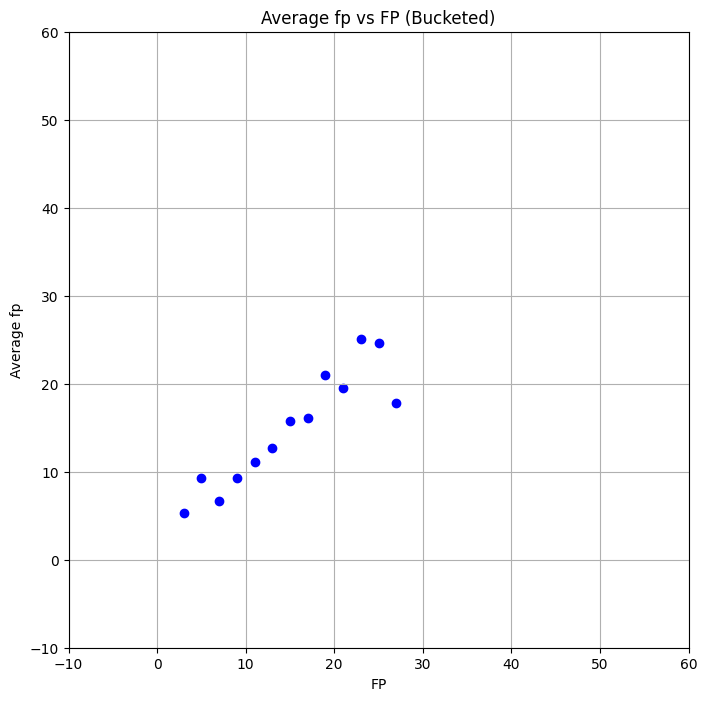

In [46]:
import numpy as np

df = pitchers_with_dff.query('starter == 1').dropna()

# Bucketing the data based on intervals of 0.5 for FP
bucket_size = 2
FP_bucketed = np.floor(df['FP'] / bucket_size) * bucket_size

# Calculating the average fp for each bucket
grouped_data = df.groupby(FP_bucketed)['fp'].mean()

# Getting the center of each bucket
bucket_centers = (grouped_data.index + bucket_size / 2)

# Creating scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(bucket_centers, grouped_data, color='blue')
plt.title('Average fp vs FP (Bucketed)')
plt.xlabel('FP')
plt.ylabel('Average fp')
plt.grid(True)

# Set the same intervals on each side from -10 to 60
plt.xlim(-10, 60)
plt.ylim(-10, 60)

plt.show()


##### Winsorized

In [47]:
# Winsorize the DataFrame
pitchers_winsorized = pitchers_with_dff.query('starter == 1')[['FP', 'FP_DFF', 'fp', 'error_me', 'error_dff', 'error_me2', 'error_dff2', 'beat_dff']].apply(lambda x: winsorize(x, limits=[0.05, 0.05]))

# Describe the winsorized DataFrame
pitchers_winsorized.describe()

,FP,FP_DFF,fp,error_me,error_dff,error_me2,error_dff2,beat_dff
count,2338.000000,2338.000000,2338.00000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000
mean,13.814731,13.871892,13.98503,0.148240,0.197626,97.161989,97.126294,0.514970
std,3.078897,3.044648,9.96727,9.360987,9.306963,114.605663,117.355376,0.499883
min,8.556101,8.200000,-3.90000,-17.354365,-17.234000,0.508080,0.511225,0.000000
25%,11.460193,11.616500,6.45000,-6.647359,-6.608000,12.008066,12.351771,0.000000
50%,13.753943,13.982000,14.15000,0.354092,0.673000,49.793487,48.177482,1.000000
75%,15.968837,16.112000,21.35000,7.401178,7.240500,138.735645,137.463907,1.000000
max,19.703472,19.210000,31.35000,16.046032,16.138000,411.568568,430.562500,1.000000


In [48]:
## Testing

In [64]:
test = batters_merged_df[~batters_merged_df['FP'].isna()][['fullName', 'imp_b_l', 'imp_b_r', 'FP', 'fp']]
test['overproject'] = (test['FP'] > test['fp']).astype(int)
test.describe()

,imp_b_l,imp_b_r,FP,fp,overproject
count,21834.000000,21834.000000,21834.000000,21827.000000,21834.000000
mean,0.075982,0.025236,7.271654,6.771567,0.642896
std,0.264976,0.156844,1.206907,6.950371,0.479157
min,0.000000,0.000000,3.999008,0.000000,0.000000
25%,0.000000,0.000000,6.402778,2.000000,0.000000
50%,0.000000,0.000000,7.161706,5.000000,1.000000
75%,0.000000,0.000000,8.045635,10.000000,1.000000
max,1.000000,1.000000,13.750000,49.000000,1.000000


In [65]:
test.groupby('imp_b_l')['overproject'].mean()

imp_b_l
0.0    0.642181
1.0    0.651597
Name: overproject, dtype: float64

In [68]:
test.groupby('imp_b_r')['overproject'].mean()

imp_b_r
0.0    0.642203
1.0    0.669691
Name: overproject, dtype: float64

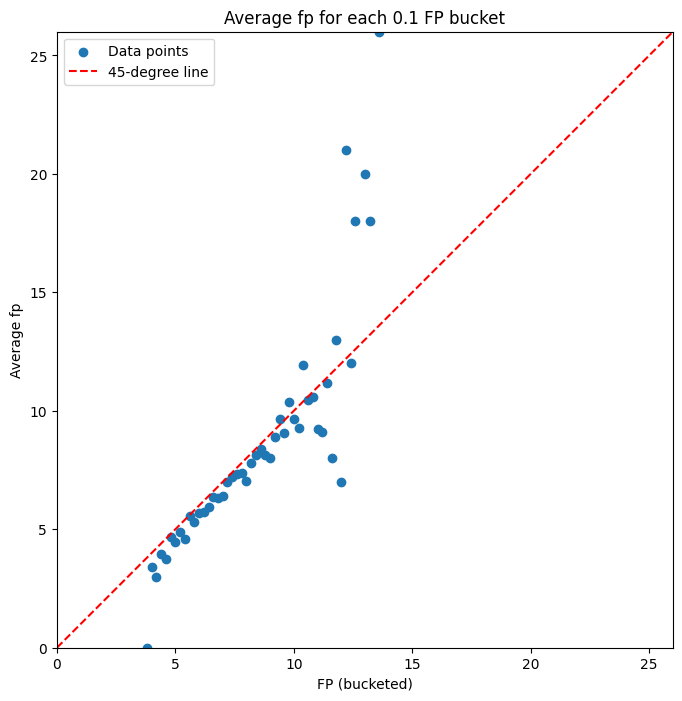

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# test = pd.DataFrame(...)

# Create buckets of 0.1 for FP
test['FP_bucket'] = np.floor(test['FP'] / 0.2) * 0.2

# Group by the buckets and calculate the mean of fp for each bucket
grouped = test.groupby('FP_bucket')['fp'].mean().reset_index()

# Scatter plot
plt.figure(figsize=(8, 8))  # Make the plot square
plt.scatter(grouped['FP_bucket'], grouped['fp'], label='Data points')
plt.xlabel('FP (bucketed)')
plt.ylabel('Average fp')
plt.title('Average fp for each 0.1 FP bucket')

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal', adjustable='box')

# Ensure the limits of the axes are the same
min_val = min(grouped['FP_bucket'].min(), grouped['fp'].min())
max_val = max(grouped['FP_bucket'].max(), grouped['fp'].max())
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Plot the 45-degree line
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='45-degree line')

plt.legend()
plt.show()


In [76]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# Sample DataFrame
# test = pd.DataFrame(...)

# Perform OLS regression with intercept set to 0
slope, intercept, r_value, p_value, std_err = linregress(test['FP'], test['fp'])

# Since we want the intercept to be 0, we calculate the slope directly without using linregress
slope = np.sum(test['FP'] * test['fp']) / np.sum(test['FP']**2)

# Calculate R-squared
r_squared = r_value**2

# Print the summary
print("OLS Regression Summary (with intercept = 0):")
print(f"Slope: {slope:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Standard Error: {std_err:.4f}")


OLS Regression Summary (with intercept = 0):
Slope: 0.9334
R-squared: nan
P-value: nan
Standard Error: nan


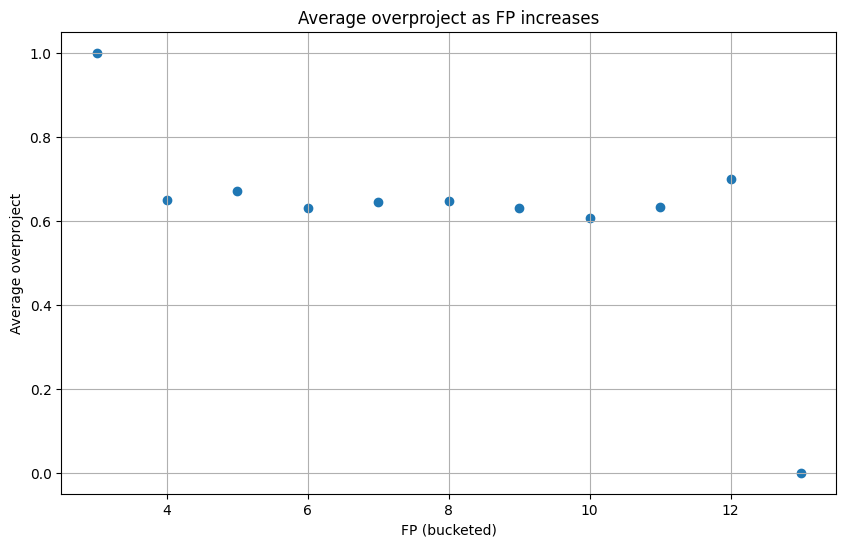

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# Assuming you have a DataFrame named 'df' with columns 'FP' and 'overproject'

# Create buckets of 10 for FP
test['FP_bucket'] = np.floor(test['FP'] / 1) * 1

# Group by the buckets and calculate the mean of overproject for each bucket
grouped = test.groupby('FP_bucket')['overproject'].mean().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped['FP_bucket'], grouped['overproject'])
plt.xlabel('FP (bucketed)')
plt.ylabel('Average overproject')
plt.title('Average overproject as FP increases')

plt.grid(True)
plt.show()


In [102]:
pitcher_test = pitchers_merged_df[~pitchers_merged_df['FP'].isna()].query('FP > 8')[['fullName', 'imp_p_l', 'imp_p_r', 'FP', 'fp']]
pitcher_test['overproject'] = (pitcher_test['FP'] > pitcher_test['fp']).astype(int)
pitcher_test.describe()

,imp_p_l,imp_p_r,FP,fp,overproject
count,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000
mean,0.051151,0.044757,14.024256,14.098103,0.485934
std,0.220352,0.206814,3.187546,10.835802,0.499909
min,0.000000,0.000000,8.026042,-23.700000,0.000000
25%,0.000000,0.000000,11.642101,6.550000,0.000000
50%,0.000000,0.000000,13.842808,14.250000,0.000000
75%,0.000000,0.000000,16.024665,21.550000,1.000000
max,1.000000,1.000000,27.176587,48.200000,1.000000


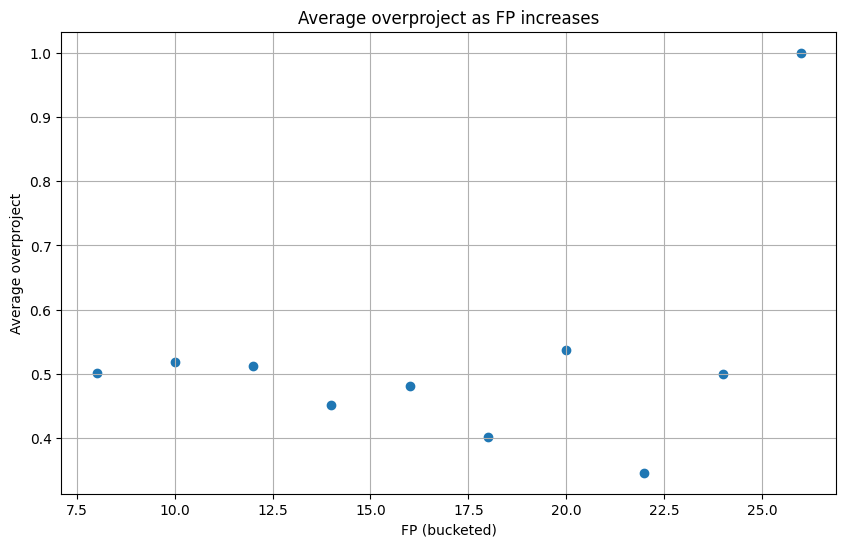

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame
# Assuming you have a DataFrame named 'df' with columns 'FP' and 'overproject'

# Create buckets of 10 for FP
pitcher_test['FP_bucket'] = np.floor(pitcher_test['FP'] / 2) * 2

# Group by the buckets and calculate the mean of overproject for each bucket
grouped = pitcher_test.groupby('FP_bucket')['overproject'].mean().reset_index()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped['FP_bucket'], grouped['overproject'])
plt.xlabel('FP (bucketed)')
plt.ylabel('Average overproject')
plt.title('Average overproject as FP increases')

plt.grid(True)
plt.show()
